# Sharp Ratio & Frontier

In [430]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

ds_yahoo = 'yahoo'

last_year = datetime.datetime.now().year - 1
start = datetime.datetime.now().replace(year=last_year)
end = datetime.datetime.now()

## Portfolio Atual

In [431]:
tickers = ['ITUB4.SA', 'ABEV3.SA', 'USIM5.SA', 'PMAM3.SA', 'FLRY3.SA', 'PSSA3.SA', 'TIET4.SA']

itau = web.DataReader(tickers[0], ds_yahoo, start, end)
abev = web.DataReader(tickers[1], ds_yahoo, start, end)
usim = web.DataReader(tickers[2], ds_yahoo, start, end)
pmam = web.DataReader(tickers[3], ds_yahoo, start, end)
flry = web.DataReader(tickers[4], ds_yahoo, start, end)
pssa = web.DataReader(tickers[5], ds_yahoo, start, end)
tiet = web.DataReader(tickers[6], ds_yahoo, start, end)

In [432]:
# USIM5     TIET11   ITUB4   PMAM3  ABEV3   FLRY3   PSSA3
# 12.30%    12.13%   28.51%  3.72%  9.54%   6.57%   27.24%

## Normalizando o retorno diário de cada ativo do portfólio

In [433]:
for acao_df in (itau, abev, usim, pmam, flry, pssa, tiet):
    acao_df['Retorno Normalizado'] = acao_df['Adj Close'] / acao_df.iloc[0]['Adj Close']

## Alocando cada ativo com um peso específico

In [434]:
# [.20, .20, .05, .05, .20, .20, .1]
for acao_df, alocacao in zip((itau, abev, usim, pmam, flry, pssa, tiet), [.2851, .0954, .1230, .0372, .0657, .2724, .1213]):
    acao_df['Alocacao'] = acao_df['Retorno Normalizado'] * alocacao

## Posição de cada ativo no portfólio

In [435]:
for acao_df in (itau, abev, usim, pmam, flry, pssa, tiet):
    acao_df['Posicao'] = acao_df['Alocacao'] * 10000

In [436]:
todas_posicoes = [itau['Posicao'], abev['Posicao'], usim['Posicao'],
                  pmam['Posicao'], flry['Posicao'], pssa['Posicao'], tiet['Posicao']]

# DF que terá colunas adicionadas como Total e Retorno Diário
portfolio_posicao = pd.concat(todas_posicoes, axis=1)

# DF que terá apenas as ações com o Adj Close column
portfolio_acoes = pd.concat(todas_posicoes, axis=1)

In [437]:
portfolio_posicao.columns = ['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET']
portfolio_acoes.columns = ['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET']

## Calculando o Total da carteira

In [438]:
portfolio_posicao['Total'] = portfolio_posicao.sum(axis=1)

In [439]:
portfolio_posicao.head()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET,Total
Date,,,,,,,,
2018-06-22,2851.000000,954.000000,1230.000000,372.000000,657.000000,2724.000000,1213.000000,10001.000000
2018-06-25,2856.794184,957.151943,1228.282180,357.119993,664.853632,2778.760617,1225.570045,10068.532594
2018-06-26,2847.369417,950.322647,1221.410651,348.191989,706.559348,2830.713437,1225.570045,10130.137534
2018-06-27,2795.919020,942.968045,1228.282180,342.239987,694.101783,2775.250507,1194.145014,9972.906535
2018-06-28,2873.458529,946.119988,1276.382636,333.312016,709.538351,2799.376409,1219.285104,10157.473032


In [440]:
portfolio_posicao.tail()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET,Total
Date,,,,,,,,
2019-06-14,3809.183886,945.740503,1511.087125,368.848936,593.828988,4029.483311,1572.264478,12830.437227
2019-06-17,3804.701072,954.318640,1500.617792,364.647528,585.021013,4079.756625,1599.489812,12888.552483
2019-06-18,3903.320835,967.721993,1532.025957,358.870588,587.862311,4096.514202,1585.877145,13032.193031
2019-06-19,3964.958026,975.764086,1511.087125,366.398123,590.987690,4101.846198,1585.877145,13096.918393
2019-06-21,4034.439927,989.167438,1516.321791,370.249405,596.670286,4124.697942,1585.877145,13217.423935


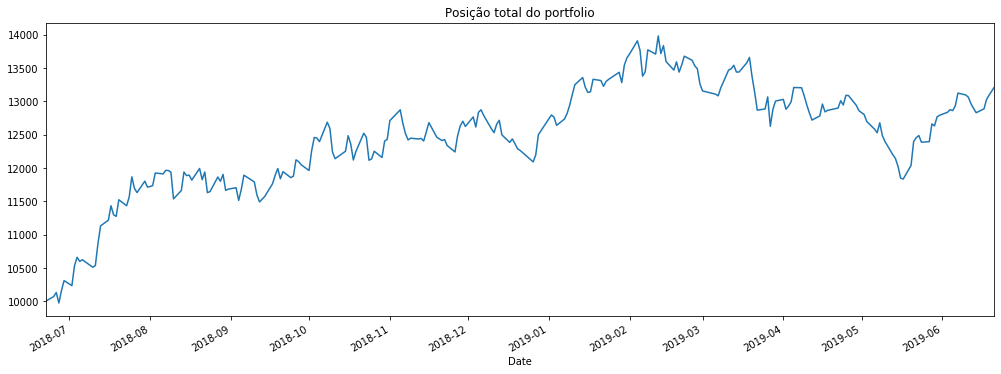

In [441]:
portfolio_posicao['Total'].plot(figsize=(17,6))
plt.title('Posição total do portfolio');

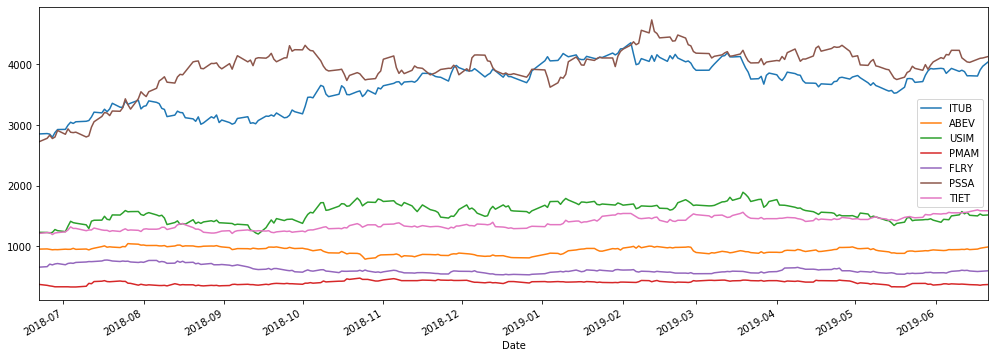

In [442]:
portfolio_posicao.drop('Total', axis=1).plot(figsize=(17,6));

## Retorno diário do Total da carteira

In [443]:
portfolio_posicao['Retorno Diario'] = portfolio_posicao['Total'].pct_change(1)

In [444]:
portfolio_posicao.head()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET,Total,Retorno Diario
Date,,,,,,,,,
2018-06-22,2851.000000,954.000000,1230.000000,372.000000,657.000000,2724.000000,1213.000000,10001.000000,NaN
2018-06-25,2856.794184,957.151943,1228.282180,357.119993,664.853632,2778.760617,1225.570045,10068.532594,0.006753
2018-06-26,2847.369417,950.322647,1221.410651,348.191989,706.559348,2830.713437,1225.570045,10130.137534,0.006119
2018-06-27,2795.919020,942.968045,1228.282180,342.239987,694.101783,2775.250507,1194.145014,9972.906535,-0.015521
2018-06-28,2873.458529,946.119988,1276.382636,333.312016,709.538351,2799.376409,1219.285104,10157.473032,0.018507


In [445]:
portfolio_posicao.tail()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET,Total,Retorno Diario
Date,,,,,,,,,
2019-06-14,3809.183886,945.740503,1511.087125,368.848936,593.828988,4029.483311,1572.264478,12830.437227,-0.004989
2019-06-17,3804.701072,954.318640,1500.617792,364.647528,585.021013,4079.756625,1599.489812,12888.552483,0.004529
2019-06-18,3903.320835,967.721993,1532.025957,358.870588,587.862311,4096.514202,1585.877145,13032.193031,0.011145
2019-06-19,3964.958026,975.764086,1511.087125,366.398123,590.987690,4101.846198,1585.877145,13096.918393,0.004967
2019-06-21,4034.439927,989.167438,1516.321791,370.249405,596.670286,4124.697942,1585.877145,13217.423935,0.009201


In [446]:
round(portfolio_posicao['Retorno Diario'].mean() * 100, 3)

0.122

In [447]:
portfolio_posicao['Retorno Diario'].std()

0.012476849514646036

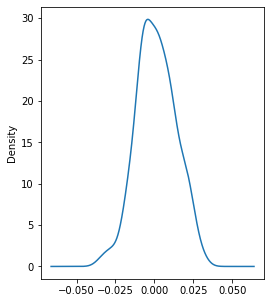

In [448]:
portfolio_posicao['Retorno Diario'].plot(kind='kde', figsize=(4,5));

In [462]:
retorno_total_acumulado = 100 * (portfolio_posicao['Total'][-1] / portfolio_posicao['Total'][0] - 1)
round(retorno_total_acumulado, 3)

32.161

In [450]:
sharpe_ratio = (portfolio_posicao['Retorno Diario'].mean()) / portfolio_posicao['Retorno Diario'].std()
sharpe_ratio

0.0978553707896189

In [451]:
sharpe_ratio_ano = (245 ** 0.5) * sharpe_ratio
sharpe_ratio_ano

1.531678827343246

## Retorno diário

In [452]:
retorno_log = portfolio_acoes.pct_change(1)

In [453]:
retorno_log.head()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET
Date,,,,,,,
2018-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-25,0.002032,0.003304,-0.001397,-0.040000,0.011954,0.020103,0.010363
2018-06-26,-0.003299,-0.007135,-0.005594,-0.025000,0.062729,0.018696,0.000000
2018-06-27,-0.018069,-0.007739,0.005626,-0.017094,-0.017631,-0.019593,-0.025641
2018-06-28,0.027733,0.003343,0.039161,-0.026087,0.022240,0.008693,0.021053


In [454]:
retorno_log.tail()

,ITUB,ABEV,USIM,PMAM,FLRY,PSSA,TIET
Date,,,,,,,
2019-06-14,0.000294,-0.011765,-0.030235,-0.006132,-0.017857,-0.001887,0.008734
2019-06-17,-0.001177,0.009070,-0.006928,-0.011391,-0.014833,0.012476,0.017316
2019-06-18,0.025921,0.014045,0.020930,-0.015843,0.004857,0.004107,-0.008511
2019-06-19,0.015791,0.008310,-0.013667,0.020976,0.005317,0.001302,0.000000
2019-06-21,0.017524,0.013736,0.003464,0.010511,0.009615,0.005571,0.000000


In [455]:
retorno_log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2018-06-22 to 2019-06-21
Data columns (total 7 columns):
ITUB    244 non-null float64
ABEV    244 non-null float64
USIM    244 non-null float64
PMAM    244 non-null float64
FLRY    244 non-null float64
PSSA    244 non-null float64
TIET    244 non-null float64
dtypes: float64(7)
memory usage: 15.3 KB


## Gerando um único portfólio com pesos aleatórios

In [456]:
print(portfolio_acoes.columns)

# Gerando pesos aleatórios
print("Pesos Aleatórios")
pesos = np.array(np.random.random(7))
print(pesos)

print("Rebalancear os pesos")
pesos = pesos / np.sum(pesos)
print(pesos)

# Retorno esperado
print("Retorno esperado")
ret_esp = np.sum( (retorno_log.mean() * weights) * 245 )
print(ret_esp)

# Volatilidade esperada
print("Volatilidade esperada")
vol_esp = np.sqrt( np.dot( pesos.T, np.dot( retorno_log.cov() * 245, pesos ) ) )
print(vol_esp)

# Taxa de Sharpe
print("Sharpe Ratio")
sharpe = ret_esp / vol_esp
print(sharpe)


Index(['ITUB', 'ABEV', 'USIM', 'PMAM', 'FLRY', 'PSSA', 'TIET'], dtype='object')
Pesos Aleatórios
[0.58610552 0.04283901 0.09200967 0.72955313 0.99184379 0.82600898
 0.13403007]
Rebalancear os pesos
[0.17226288 0.01259086 0.02704266 0.21442371 0.29151383 0.24277315
 0.03939292]
Retorno esperado
1.1527550617214908
Volatilidade esperada
0.20637861057759302
Sharpe Ratio
5.585632437854235


## Gerando milhares de portfólios

In [457]:
num_portfolios = 10000
pesos_arr = np.zeros((num_portfolios, len(portfolio_acoes.columns)))
ret_esp_arr = np.zeros(num_portfolios)
vol_esp_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for ind in range(num_portfolios):

    # Pesos aleatórios
    pesos = np.array(np.random.random(7))
    pesos = pesos / np.sum(pesos)
    pesos_arr[ind,:] = pesos

    # Retorno esperado
    ret_esp_arr[ind] = np.sum( (retorno_log.mean() * pesos) * 245 )

    # Volatilidade esperada
    vol_esp_arr[ind] = np.sqrt( np.dot( pesos.T, np.dot( retorno_log.cov() * 245, pesos ) ) )

    # Taxa de Sharpe
    sharpe_arr[ind] = (ret_esp_arr[ind] - 0.065) / vol_esp_arr[ind]

pesos_arr[sharpe_arr.argmax(),:]

array([0.18355244, 0.08174146, 0.06651157, 0.04623709, 0.00046225,
       0.32593133, 0.29556387])

In [458]:
sharpe_arr.max()

1.5308664306620055

In [459]:
sharpe_arr.argmax()

5319

In [460]:
pesos_arr[sharpe_arr.argmax(),:]

array([0.18355244, 0.08174146, 0.06651157, 0.04623709, 0.00046225,
       0.32593133, 0.29556387])